In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency

In [2]:
loan_data = pd.read_csv('Random Data_Final 123.csv')

In [3]:
pd.options.display.max_columns = None
loan_data.head()

,Loan_Amount,Age_Years,Marital_Status,Level_of_Education,Employment_Type,Total_Years_of_Service,Number_of_years_at_Present_Employment,Grade,Monthly_Income,Accommodation,Average_Balances_last_6_Months,Geo-Region,OCCUPATION,DPD_category
0,200000,31 to 40,Married,Non Graduate,Govt Parastatal,8 to 10,>5,Junior level,<100000,Rented,3818,North Central,OTHERS,0
1,500000,51 to 55,Married,Non Graduate,Govt Parastatal,Above 15,>5,Junior level,100001 to 250000,Rented,7300,North East,CIVIL SERVANT,0
2,330000,41 to 50,Single,Graduate,Govt Parastatal,10 to 15,>5,Junior level,<100000,Rented,235,North Central,MILITARY PERSONNEL,0
3,25203000,51 to 55,Married,Graduate,Govt Parastatal,Above 15,>5,Senior Manager,1000001 to 2000000,Owned,3626032,Abuja,CIVIL SERVANT,0
4,10522574,31 to 40,Married,Post Graduate,Govt Parastatal,4 to 7,5,Middle Manager,250001 to 500000,Rented,60563,Lagos,OTHERS,0


In [4]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3248 entries, 0 to 3247
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Loan_Amount                            3248 non-null   int64 
 1   Age_Years                              3248 non-null   object
 2   Marital_Status                         3248 non-null   object
 3   Level_of_Education                     3248 non-null   object
 4   Employment_Type                        3248 non-null   object
 5   Total_Years_of_Service                 3248 non-null   object
 6   Number_of_years_at_Present_Employment  3248 non-null   object
 7   Grade                                  3248 non-null   object
 8   Monthly_Income                         3248 non-null   object
 9   Accommodation                          3248 non-null   object
 10  Average_Balances_last_6_Months         3248 non-null   object
 11  Geo-Region       

In [5]:
null_values = loan_data.isnull().sum()
print(null_values)

Loan_Amount                              0
Age_Years                                0
Marital_Status                           0
Level_of_Education                       0
Employment_Type                          0
Total_Years_of_Service                   0
Number_of_years_at_Present_Employment    0
Grade                                    0
Monthly_Income                           0
Accommodation                            0
Average_Balances_last_6_Months           0
Geo-Region                               0
OCCUPATION                               0
DPD_category                             0
dtype: int64


In [6]:
loan_data['DPD_category'].value_counts(normalize = True)

0    0.946429
1    0.053571
Name: DPD_category, dtype: float64

In [7]:
loan_data['good_bad'] = np.where(loan_data['DPD_category'].astype(float), 0, 1)
loan_data.drop(columns = ['DPD_category'], inplace = True)

In [8]:
loan_data.head()

,Loan_Amount,Age_Years,Marital_Status,Level_of_Education,Employment_Type,Total_Years_of_Service,Number_of_years_at_Present_Employment,Grade,Monthly_Income,Accommodation,Average_Balances_last_6_Months,Geo-Region,OCCUPATION,good_bad
0,200000,31 to 40,Married,Non Graduate,Govt Parastatal,8 to 10,>5,Junior level,<100000,Rented,3818,North Central,OTHERS,1
1,500000,51 to 55,Married,Non Graduate,Govt Parastatal,Above 15,>5,Junior level,100001 to 250000,Rented,7300,North East,CIVIL SERVANT,1
2,330000,41 to 50,Single,Graduate,Govt Parastatal,10 to 15,>5,Junior level,<100000,Rented,235,North Central,MILITARY PERSONNEL,1
3,25203000,51 to 55,Married,Graduate,Govt Parastatal,Above 15,>5,Senior Manager,1000001 to 2000000,Owned,3626032,Abuja,CIVIL SERVANT,1
4,10522574,31 to 40,Married,Post Graduate,Govt Parastatal,4 to 7,5,Middle Manager,250001 to 500000,Rented,60563,Lagos,OTHERS,1


In [9]:
# split data into 80/20 while keeping the distribution of bad loans in test set same as that in the pre-split dataset
X = loan_data.drop('good_bad', axis = 1)
y = loan_data['good_bad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
X_train, X_test = X_train.copy(), X_test.copy()

In [10]:
# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in X_train:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result

,Feature,p-value
0,Employment_Type,3.400000e-09
1,Loan_Amount,1.087730e-05
2,Geo-Region,5.105990e-05
3,OCCUPATION,9.570894e-04
4,Total_Years_of_Service,1.757522e-02
5,Level_of_Education,3.188665e-02
6,Accommodation,4.645372e-02
7,Age_Years,1.062446e-01
8,Grade,1.725040e-01
9,Monthly_Income,2.483614e-01


In [11]:
for column in X_train:
    print(f"Unique values in {column}: {X_train[column].unique()}")

Unique values in Loan_Amount: [   500000    800000    350000    600000    220000  32247000    750000
    140000    240000    200000    250000    900000    260000    720000
    492000   1050000    170000   1580000    550000    320000    470000
    300000    490000    650000    280000    295000    411844    415000
    390000   1852000    380000    680000    125000    450000   1600000
    570000    360000    225000    460000   1400000   1300000   1500000
    530000    560000    100000   1000000   5000000    190000   2000000
    663000    540000    700000    400000    189000    590000   1200000
   4000000   2600000    790000    420000   1100000    738000    786000
    340000    620000    230000    854000    605000    180000    119000
   2220000   1750000   1880000    232000    462000   4500000  10000000
    820000    658000    980000   2676000   1127000    258000    589000
    150000    830000    760000    210000    204000   1260000   3000000
    630000    208000   1194000    330000    595

In [12]:
print(y_train.value_counts())

1    2459
0     139
Name: good_bad, dtype: int64


In [13]:
for column in X_train:
    observed = pd.crosstab(y_train, X_train[column])
    chi, p, dof, ex = chi2_contingency(observed)
    print(f"Column: {column}, p-value: {p}")

Column: Loan_Amount, p-value: 1.0877250383753838e-05
Column: Age_Years, p-value: 0.10624455774987404
Column: Marital_Status, p-value: 1.0
Column: Level_of_Education, p-value: 0.031886651887880056
Column: Employment_Type, p-value: 3.3781014999513384e-09
Column: Total_Years_of_Service, p-value: 0.01757521908906012
Column: Number_of_years_at_Present_Employment, p-value: 0.7074585883613873
Column: Grade, p-value: 0.17250397269935958
Column: Monthly_Income, p-value: 0.24836144943157476
Column: Accommodation, p-value: 0.04645372000632808
Column: Average_Balances_last_6_Months, p-value: 0.9995374386175715
Column: Geo-Region, p-value: 5.1059915155457776e-05
Column: OCCUPATION, p-value: 0.0009570893529737795


In [14]:
X_train_prepr = X_train.copy()
y_train_prepr = y_train.copy()
X_test_prepr = X_test.copy()
y_test_prepr = y_test.copy()

In [15]:
def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [16]:
sns.set()
# Below we define a function for plotting WoE across categories that takes 2 arguments: a dataframe and a number.
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

In [17]:
df_temp = woe_discrete(X_train_prepr, 'Loan_Amount', y_train_prepr)
df_temp

/Users/akshita/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Loan_Amount,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,234000,1,0.0,0.000385,0.0,1.0,0.000000,0.007194,-inf,NaN,NaN,inf
1,1030000,1,0.0,0.000385,0.0,1.0,0.000000,0.007194,-inf,0.0,NaN,inf
2,522000,1,0.0,0.000385,0.0,1.0,0.000000,0.007194,-inf,0.0,NaN,inf
3,529194,1,0.0,0.000385,0.0,1.0,0.000000,0.007194,-inf,0.0,NaN,inf
4,544000,1,0.0,0.000385,0.0,1.0,0.000000,0.007194,-inf,0.0,NaN,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
457,475000,1,1.0,0.000385,1.0,0.0,0.000407,0.000000,inf,0.0,NaN,inf
458,472000,1,1.0,0.000385,1.0,0.0,0.000407,0.000000,inf,0.0,NaN,inf
459,468000,3,1.0,0.001155,3.0,0.0,0.001220,0.000000,inf,0.0,NaN,inf
460,491000,1,1.0,0.000385,1.0,0.0,0.000407,0.000000,inf,0.0,NaN,inf


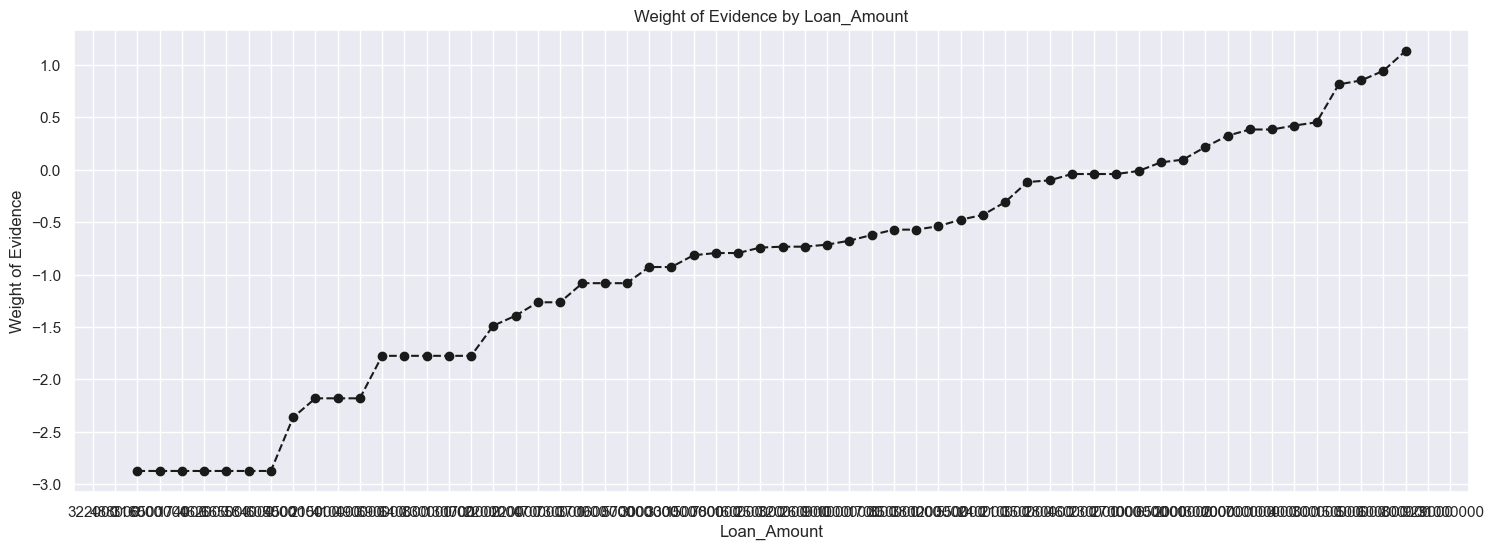

In [18]:
plot_by_woe(df_temp)

In [19]:
df_temp = woe_discrete(X_train_prepr, 'Age_Years', y_train_prepr)
df_temp

,Age_Years,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,31 to 40,805,0.930435,0.309854,749.0,56.0,0.304595,0.402878,-0.279649,NaN,NaN,inf
1,51 to 55,321,0.937695,0.123557,301.0,20.0,0.122407,0.143885,-0.161658,0.007260,0.117991,inf
2,41 to 50,1098,0.954463,0.422633,1048.0,50.0,0.426190,0.359712,0.169580,0.016768,0.331238,inf
3,>55,231,0.961039,0.088915,222.0,9.0,0.090281,0.064748,0.332417,0.006576,0.162837,inf
4,26 to 30,126,0.968254,0.048499,122.0,4.0,0.049614,0.028777,0.544691,0.007215,0.212274,inf
5,21 to 25,17,1.000000,0.006543,17.0,0.0,0.006913,0.000000,inf,0.031746,inf,inf


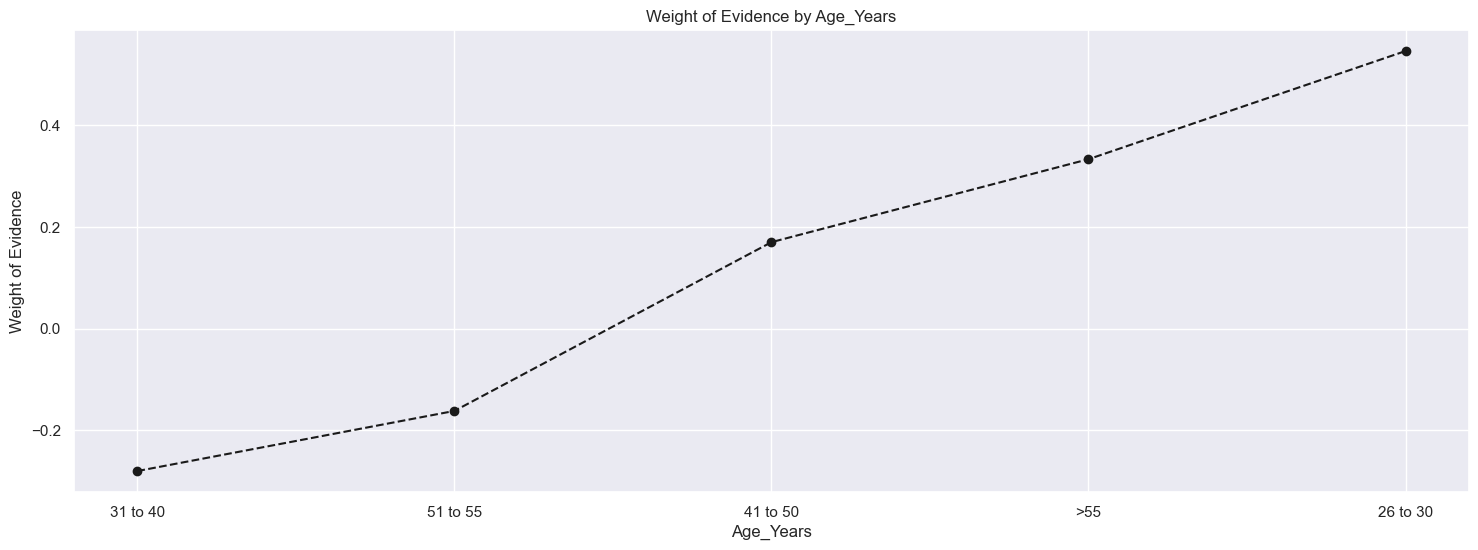

In [20]:
plot_by_woe(df_temp)

In [21]:
df_temp = woe_discrete(X_train_prepr, 'Marital_Status', y_train_prepr)
df_temp

,Marital_Status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Married,2309,0.946297,0.888761,2185.0,124.0,0.888573,0.892086,-0.003947,NaN,NaN,0.000126
1,Single,289,0.948097,0.111239,274.0,15.0,0.111427,0.107914,0.032042,0.0018,0.035988,0.000126


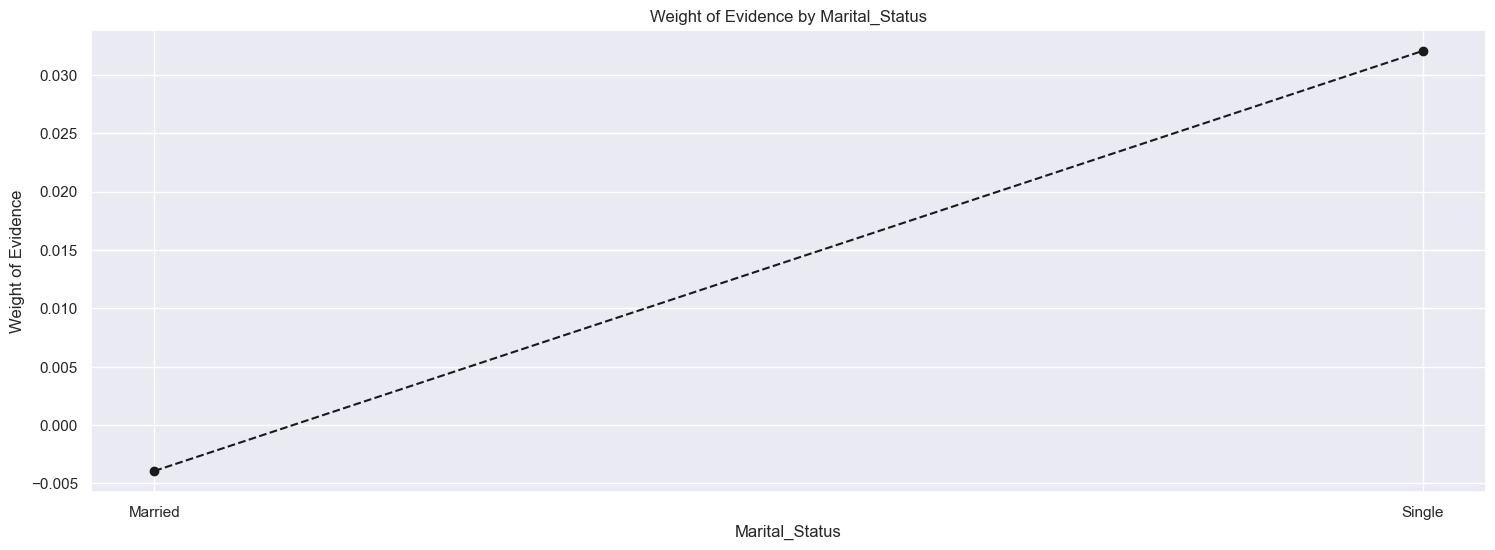

In [22]:
plot_by_woe(df_temp)

In [23]:
    df_temp = woe_discrete(X_train_prepr, 'Level_of_Education', y_train_prepr)
df_temp

,Level_of_Education,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Doctorate,42,0.880952,0.016166,37.0,5.0,0.015047,0.035971,-0.871556,NaN,NaN,0.061663
1,Graduate,1552,0.939433,0.597383,1458.0,94.0,0.592924,0.676259,-0.131510,0.058481,0.740046,0.061663
2,Non Graduate,742,0.959569,0.285604,712.0,30.0,0.289549,0.215827,0.293844,0.020136,0.425354,0.061663
3,Post Graduate,262,0.961832,0.100847,252.0,10.0,0.102481,0.071942,0.353808,0.002263,0.059963,0.061663


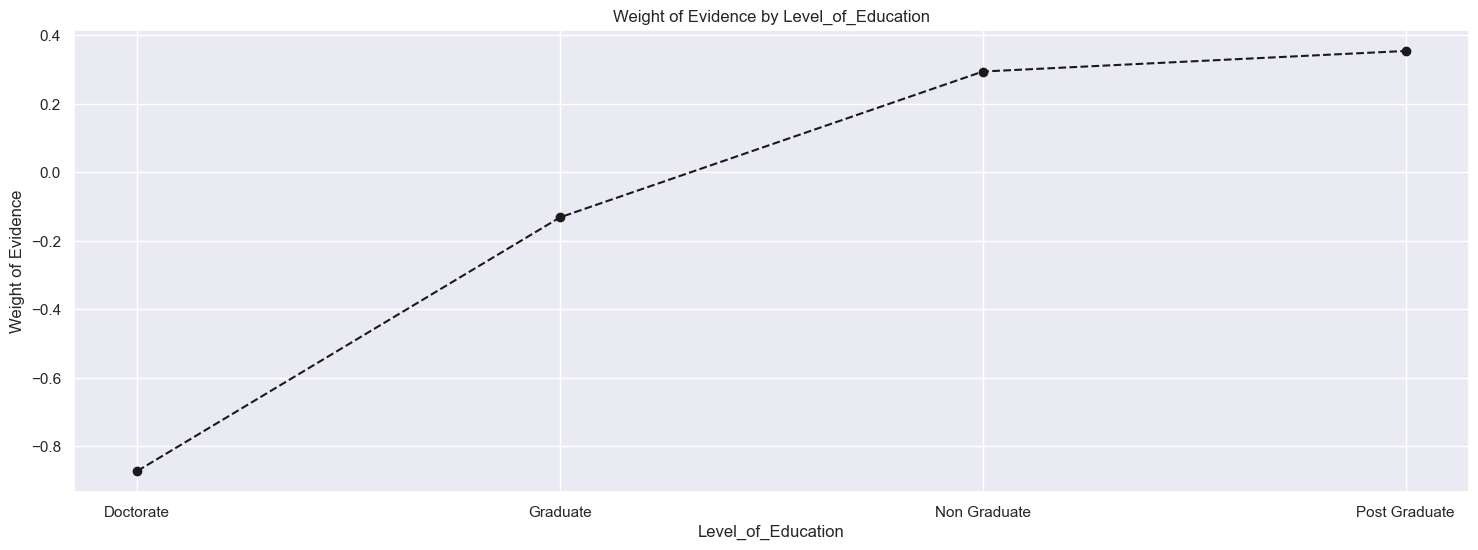

In [24]:
plot_by_woe(df_temp)

In [25]:
df_temp = woe_discrete(X_train_prepr, 'Employment_Type', y_train_prepr)
df_temp

,Employment_Type,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Quoted Company,247,0.890688,0.095073,220.0,27.0,0.089467,0.194245,-0.775245,NaN,NaN,0.236268
1,Private Company,280,0.892857,0.107775,250.0,30.0,0.101667,0.215827,-0.752773,0.002169,0.022473,0.236268
2,Govt Parastatal,2071,0.960406,0.797152,1989.0,82.0,0.808865,0.589928,0.315632,0.067548,1.068404,0.236268


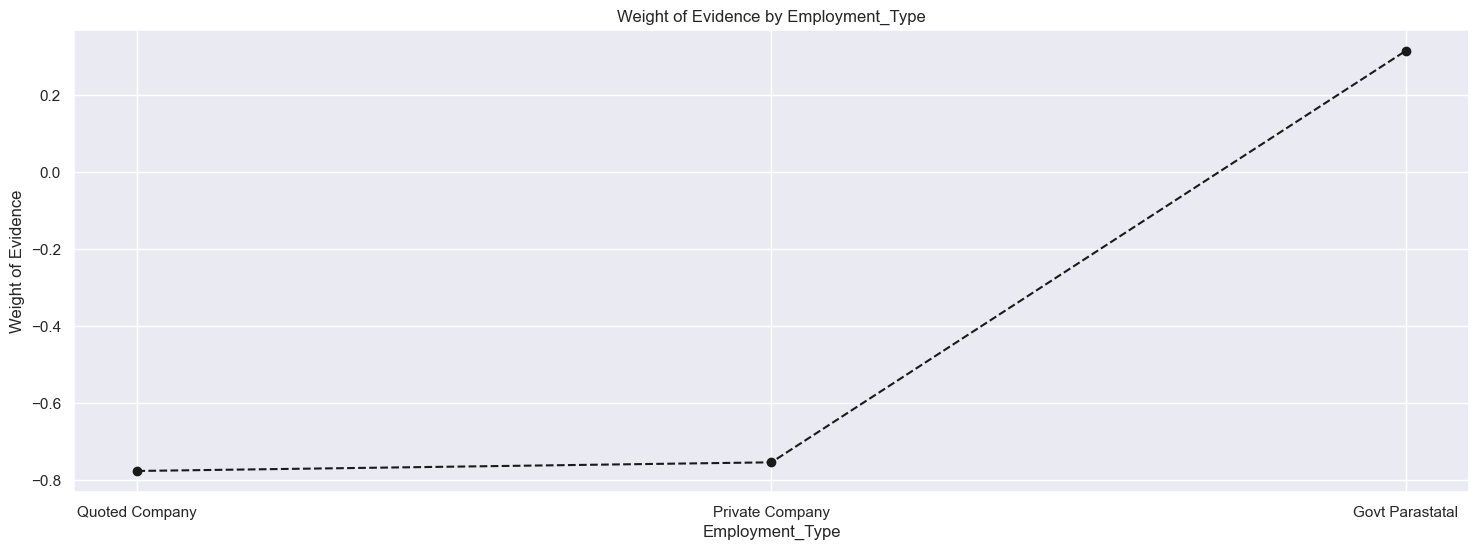

In [26]:
plot_by_woe(df_temp)

In [27]:
df_temp = woe_discrete(X_train_prepr, 'Total_Years_of_Service', y_train_prepr)
df_temp

,Total_Years_of_Service,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,1 to 3,186,0.919355,0.071594,171.0,15.0,0.069540,0.107914,-0.439423,NaN,NaN,0.088157
1,4 to 7,469,0.925373,0.180523,434.0,35.0,0.176495,0.251799,-0.355340,0.006018,0.084083,0.088157
2,8 to 10,379,0.939314,0.145881,356.0,23.0,0.144774,0.165468,-0.133600,0.013941,0.221740,0.088157
3,10 to 15,527,0.950664,0.202848,501.0,26.0,0.203741,0.187050,0.085473,0.011350,0.219073,0.088157
4,Above 15,1037,0.961427,0.399153,997.0,40.0,0.405449,0.287770,0.342835,0.010763,0.257362,0.088157


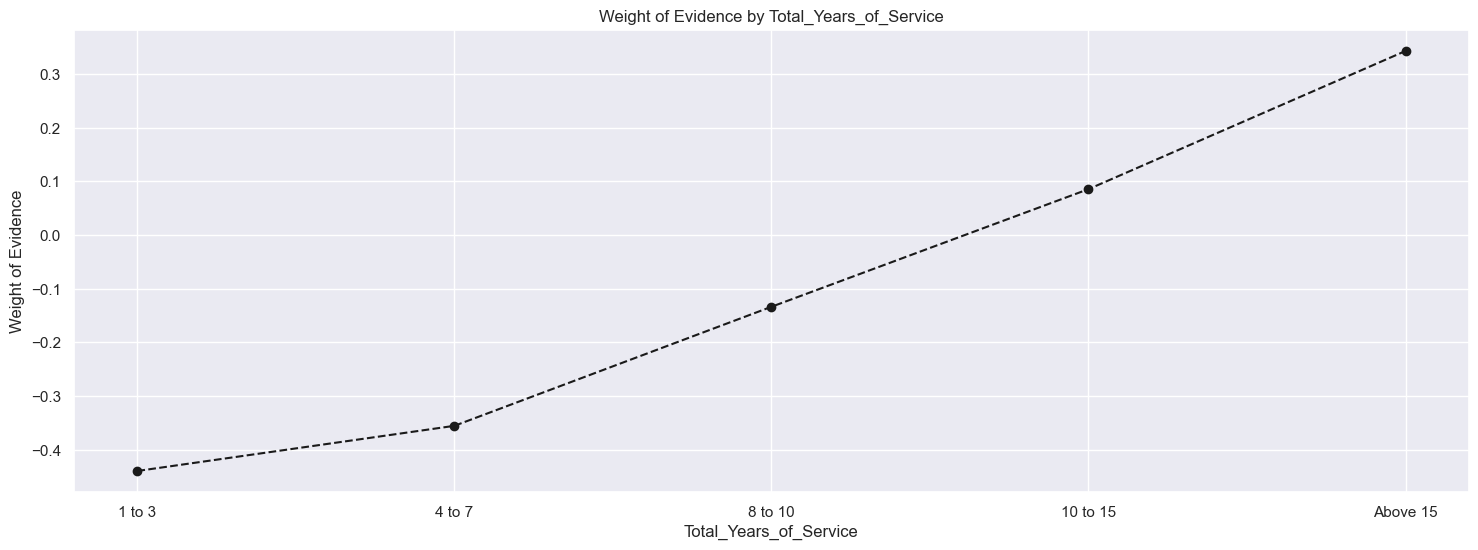

In [28]:
plot_by_woe(df_temp)

In [29]:
df_temp = woe_discrete(X_train_prepr, 'Number_of_years_at_Present_Employment', y_train_prepr)
df_temp

,Number_of_years_at_Present_Employment,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,1,29,0.896552,0.011162,26.0,3.0,0.010573,0.021583,-0.713552,NaN,NaN,0.018226
1,2,81,0.925926,0.031178,75.0,6.0,0.030500,0.043165,-0.347307,0.029374,0.366244,0.018226
2,5,131,0.931298,0.050423,122.0,9.0,0.049614,0.064748,-0.266240,0.005372,0.081068,0.018226
3,3,115,0.947826,0.044265,109.0,6.0,0.044327,0.043165,0.026552,0.016528,0.292792,0.018226
4,>5,2117,0.948512,0.814858,2008.0,109.0,0.816592,0.784173,0.040510,0.000686,0.013958,0.018226
5,4,125,0.952000,0.048114,119.0,6.0,0.048394,0.043165,0.114328,0.003488,0.073817,0.018226


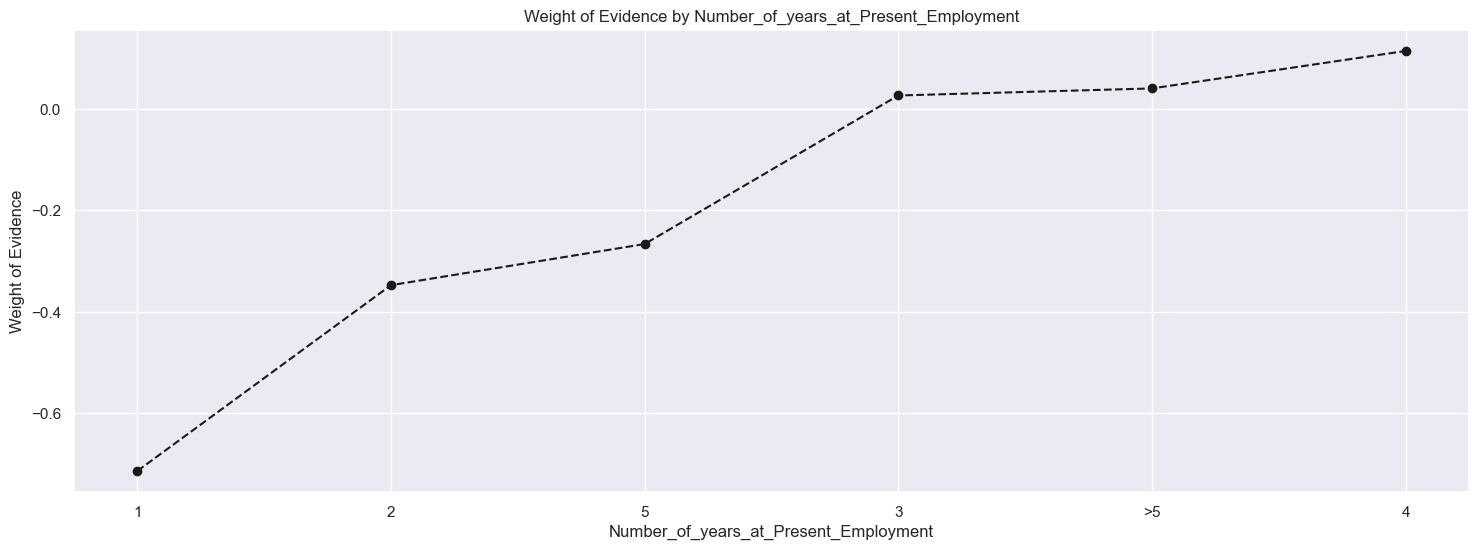

In [30]:
plot_by_woe(df_temp)

In [31]:
df_temp = woe_discrete(X_train_prepr, 'Grade', y_train_prepr)
df_temp

,Grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Senior Manager,228,0.921053,0.087760,210.0,18.0,0.085401,0.129496,-0.416300,NaN,NaN,0.023211
1,Junior level,1789,0.947457,0.688607,1695.0,94.0,0.689305,0.676259,0.019107,0.026404,0.435407,0.023211
2,Middle Manager,581,0.953528,0.223634,554.0,27.0,0.225295,0.194245,0.148292,0.006072,0.129185,0.023211


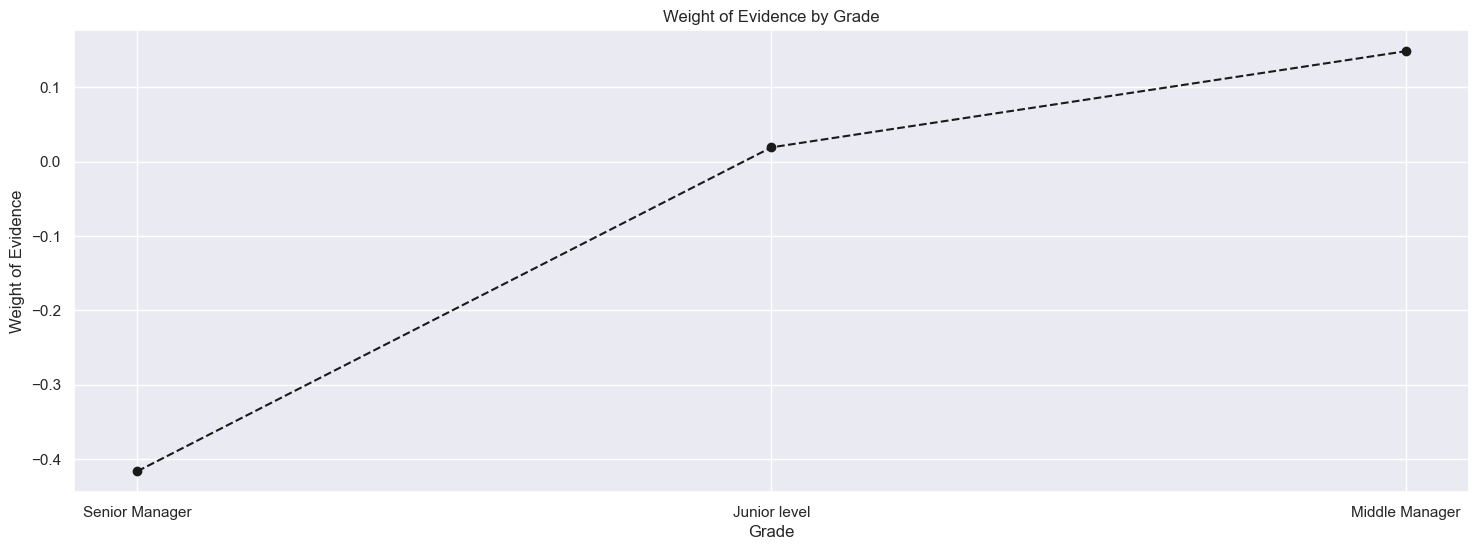

In [32]:
plot_by_woe(df_temp)

In [33]:
df_temp = woe_discrete(X_train_prepr, 'Monthly_Income', y_train_prepr)
df_temp

,Monthly_Income,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,500001 to 1000000,74,0.891892,0.028483,66.0,8.0,0.026840,0.057554,-0.762823,NaN,NaN,inf
1,> 5000000,11,0.909091,0.004234,10.0,1.0,0.004067,0.007194,-0.570451,0.017199,0.192372,inf
2,250001 to 500000,199,0.939698,0.076597,187.0,12.0,0.076047,0.086331,-0.126834,0.030608,0.443617,inf
3,<100000,1400,0.945714,0.538876,1324.0,76.0,0.538430,0.546763,-0.015357,0.006016,0.111477,inf
4,100001 to 250000,869,0.951669,0.334488,827.0,42.0,0.336316,0.302158,0.107099,0.005954,0.122456,inf
5,1000001 to 2000000,30,1.000000,0.011547,30.0,0.0,0.012200,0.000000,inf,0.048331,inf,inf
6,2000001 to 5000000,15,1.000000,0.005774,15.0,0.0,0.006100,0.000000,inf,0.000000,NaN,inf


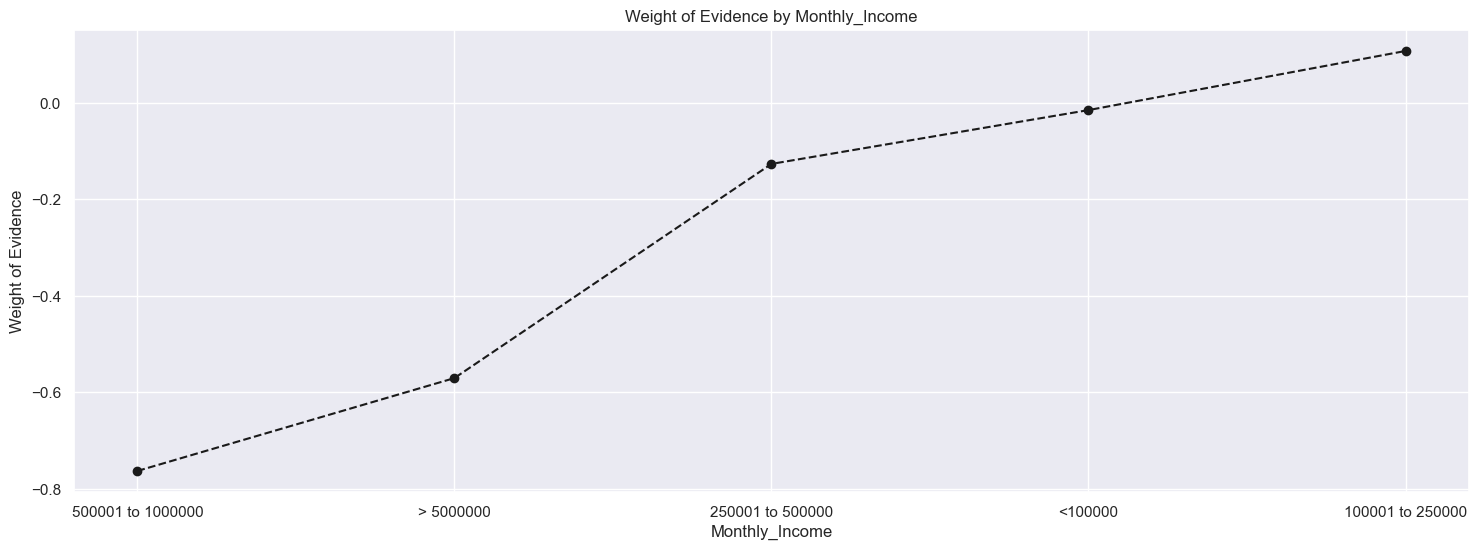

In [34]:
plot_by_woe(df_temp)

In [35]:
df_temp = woe_discrete(X_train_prepr, 'Accommodation', y_train_prepr)
df_temp

,Accommodation,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Rented,1390,0.936691,0.535027,1302.0,88.0,0.529484,0.633094,-0.178716,NaN,NaN,0.049094
1,Staying with Family,414,0.951691,0.159353,394.0,20.0,0.160228,0.143885,0.107583,0.015000,0.286299,0.049094
2,Owned,794,0.960957,0.305620,763.0,31.0,0.310289,0.223022,0.330235,0.009266,0.222652,0.049094


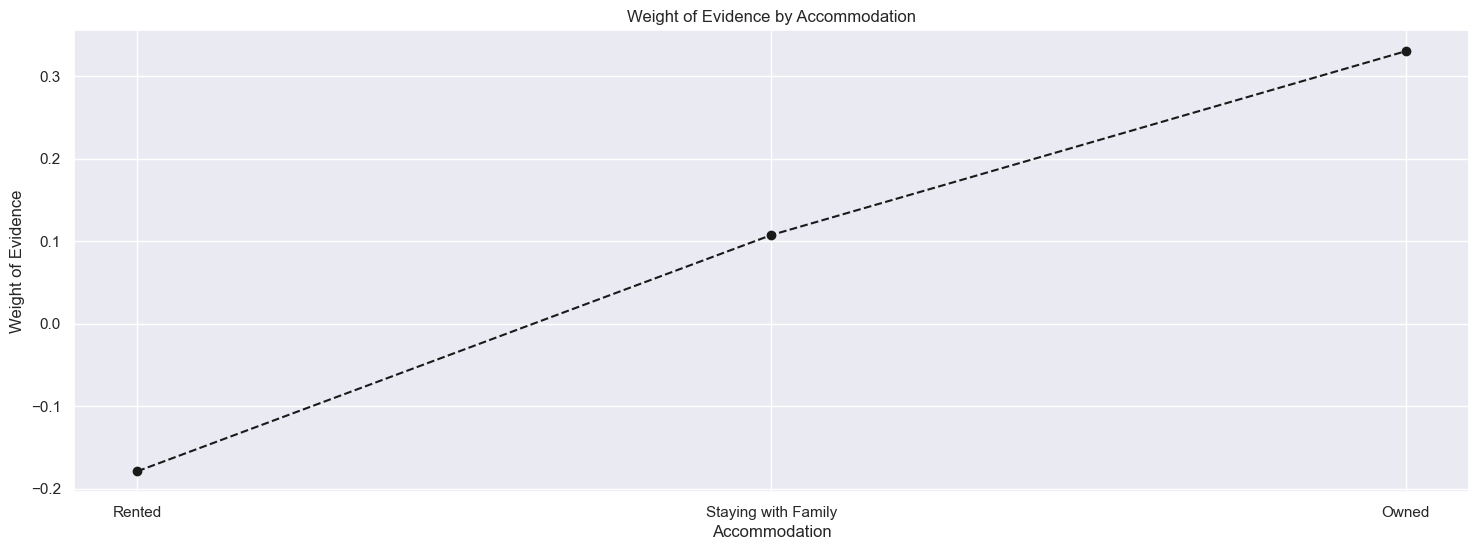

In [36]:
plot_by_woe(df_temp)

In [37]:
df_temp = woe_discrete(X_train_prepr, 'Average_Balances_last_6_Months', y_train_prepr)
df_temp

/Users/akshita/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Average_Balances_last_6_Months,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,3278,1,0.0,0.000385,0.0,1.0,0.000000,0.007194,-inf,NaN,NaN,inf
1,461,1,0.0,0.000385,0.0,1.0,0.000000,0.007194,-inf,0.0,NaN,inf
2,103,2,0.0,0.000770,0.0,2.0,0.000000,0.014388,-inf,0.0,NaN,inf
3,187,1,0.0,0.000385,0.0,1.0,0.000000,0.007194,-inf,0.0,NaN,inf
4,13400,1,0.0,0.000385,0.0,1.0,0.000000,0.007194,-inf,0.0,NaN,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
2358,214,1,1.0,0.000385,1.0,0.0,0.000407,0.000000,inf,0.0,NaN,inf
2359,2144,2,1.0,0.000770,2.0,0.0,0.000813,0.000000,inf,0.0,NaN,inf
2360,214441,1,1.0,0.000385,1.0,0.0,0.000407,0.000000,inf,0.0,NaN,inf
2361,204046,1,1.0,0.000385,1.0,0.0,0.000407,0.000000,inf,0.0,NaN,inf


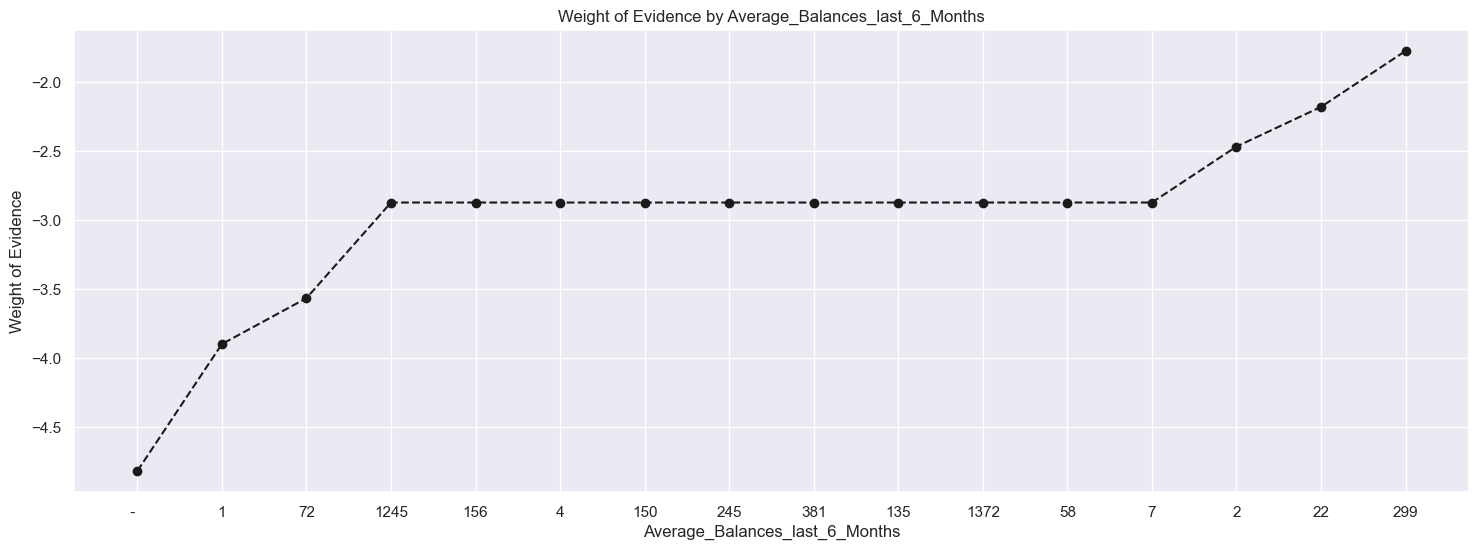

In [38]:
plot_by_woe(df_temp)

In [39]:
df_temp = woe_discrete(X_train_prepr, 'Geo-Region', y_train_prepr)
df_temp

,Geo-Region,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Lagos,394,0.908629,0.151655,358.0,36.0,0.145588,0.258993,-0.576022,NaN,NaN,0.249922
1,North Central,364,0.925824,0.140108,337.0,27.0,0.137048,0.194245,-0.348790,0.017195,0.227232,0.249922
2,South South,415,0.927711,0.159738,385.0,30.0,0.156568,0.215827,-0.320990,0.001887,0.027800,0.249922
3,South East,169,0.952663,0.065050,161.0,8.0,0.065474,0.057554,0.128927,0.024952,0.449917,0.249922
4,South West,131,0.954198,0.050423,125.0,6.0,0.050834,0.043165,0.163518,0.001536,0.034591,0.249922
5,North West,669,0.970105,0.257506,649.0,20.0,0.263928,0.143885,0.606664,0.015906,0.443146,0.249922
6,North East,247,0.971660,0.095073,240.0,7.0,0.097601,0.050360,0.661693,0.001555,0.055028,0.249922
7,Abuja,209,0.976077,0.080446,204.0,5.0,0.082961,0.035971,0.835646,0.004417,0.173953,0.249922


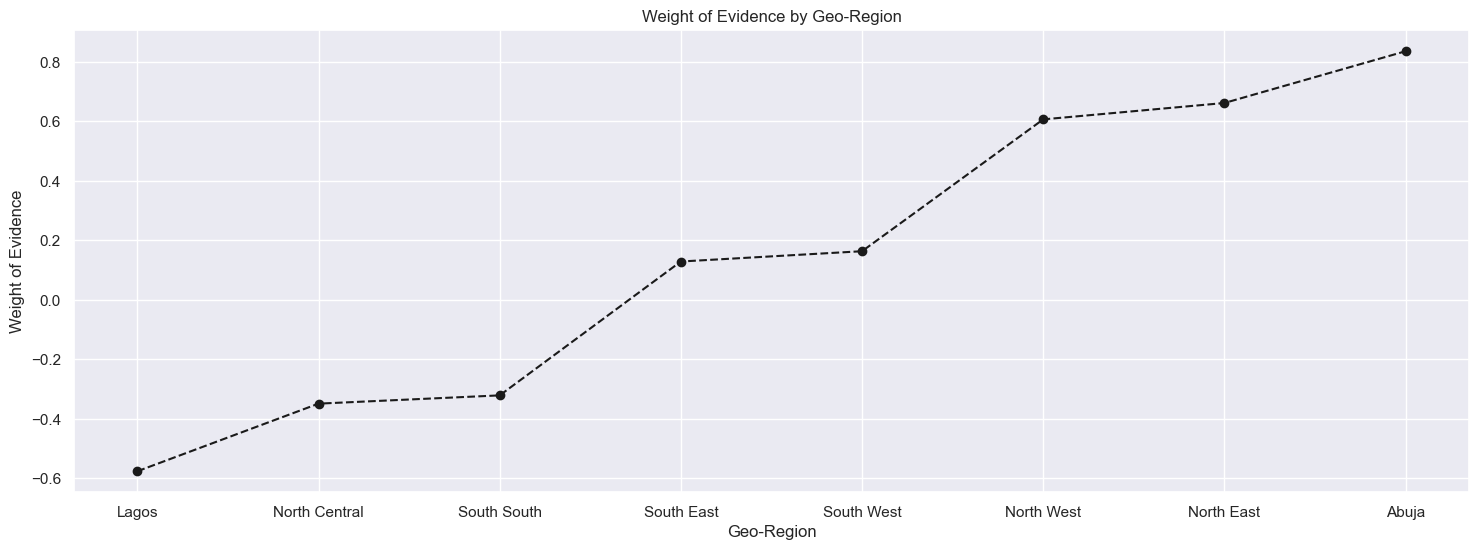

In [40]:
plot_by_woe(df_temp)

In [41]:
df_temp = woe_discrete(X_train_prepr, 'OCCUPATION', y_train_prepr)
df_temp

,OCCUPATION,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,PROFESSIONAL,82,0.902439,0.031563,74.0,8.0,0.030094,0.057554,-0.648413,NaN,NaN,inf
1,BUSINESS TRADER,63,0.920635,0.024249,58.0,5.0,0.023587,0.035971,-0.422031,0.018196,0.226382,inf
2,OTHERS,1034,0.929400,0.397998,961.0,73.0,0.390809,0.525180,-0.295521,0.008765,0.126510,inf
3,CIVIL SERVANT,1152,0.959201,0.443418,1105.0,47.0,0.449370,0.338129,0.284417,0.029801,0.579938,inf
4,EDUCATIONIST,155,0.961290,0.059661,149.0,6.0,0.060594,0.043165,0.339151,0.002089,0.054734,inf
5,MILITARY PERSONNEL,112,1.000000,0.043110,112.0,0.0,0.045547,0.000000,inf,0.038710,inf,inf


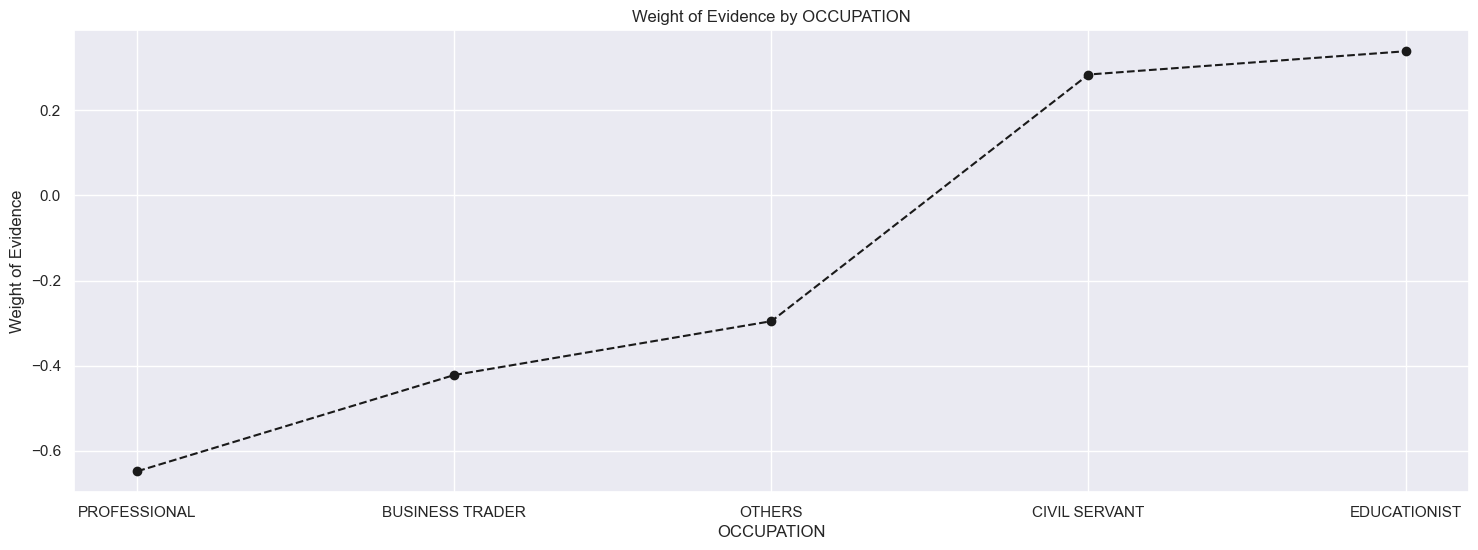

In [42]:
plot_by_woe(df_temp)

In [43]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2598, 13)
(2598,)
(650, 13)
(650,)


In [44]:
global_features = [
    'Loan_Amount',
    'Age_Years',
    'Marital_Status',
    'Level_of_Education',
    'Employment_Type',
    'Total_Years_of_Service',
    'Number_of_years_at_Present_Employment',
    'Grade',
    'Monthly_Income',
    'Accommodation',
    'Average_Balances_last_6_Months',
    'Geo-Region',
    'OCCUPATION',
]

# Create a list of reference categories
ref_categories = []
for feature in global_features:
    ref_category = f'{feature}:{loan_data[feature].mode().values[0]}'  # Using the mode as the reference
    ref_categories.append(ref_category)

print(ref_categories)

['Loan_Amount:500000', 'Age_Years:41 to 50', 'Marital_Status:Married', 'Level_of_Education:Graduate', 'Employment_Type:Govt Parastatal', 'Total_Years_of_Service:Above 15', 'Number_of_years_at_Present_Employment:>5', 'Grade:Junior level', 'Monthly_Income:<100000', 'Accommodation:Rented', 'Average_Balances_last_6_Months:1', 'Geo-Region:North West', 'OCCUPATION:CIVIL SERVANT']


In [45]:
ref_categories = [
    'Loan_Amount',
    'Age_Years',
    'Marital_Status',
    'Level_of_Education',
    'Employment_Type',
    'Total_Years_of_Service',
    'Number_of_years_at_Present_Employment',
    'Grade',
    'Monthly_Income',
    'Accommodation',
    'Average_Balances_last_6_Months',
    'Geo-Region',
    'OCCUPATION',
]


In [46]:
global_features = [
    'Loan_Amount',
    'Age_Years',
    'Marital_Status',
    'Level_of_Education',
    'Employment_Type',
    'Total_Years_of_Service',
    'Number_of_years_at_Present_Employment',
    'Grade',
    'Monthly_Income',
    'Accommodation',
    'Average_Balances_last_6_Months',
    'Geo-Region',
    'OCCUPATION',
]

In [47]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class WoE_Binning(BaseEstimator, TransformerMixin):
    #def __init__(self):  # No need to pass X during initialization
        #pass
    
    def __init__(self, global_features):  # Accept global_features as a parameter
        self.global_features = global_features
    
    def fit(self, X, y=None):
        return self  # Nothing else to do
    
    def transform(self, X):
        X_new = pd.DataFrame()
        
        X_new['Loan_Amount:<500000'] = np.where((X['Loan_Amount'] == '< 500000'), 1, 0)
        X_new['Loan_Amount:500000-1000000'] = np.where((X['Loan_Amount'] == '500000-1000000'), 1, 0)
        X_new['Loan_Amount:>1000000'] = np.where((X['Loan_Amount'] == '> 1000000'), 1, 0)

        X_new['Age_Years:21 to 25'] = np.where((X['Age_Years'] == '31 to 40'), 1, 0)
        X_new['Age_Years:26 to 30'] = np.where((X['Age_Years'] == '41 to 50'), 1, 0)
        X_new['Age_Years:31 to 40'] = np.where((X['Age_Years'] == '31 to 40'), 1, 0)
        X_new['Age_Years:41 to 50'] = np.where((X['Age_Years'] == '41 to 50'), 1, 0)
        X_new['Age_Years:51 to 55'] = np.where((X['Age_Years'] == '51 to 55'), 1, 0)
        X_new['Age_Years:>55'] = np.where((X['Age_Years'] == '>55'), 1, 0)
        
        X_new['Marital_Status:Single'] = np.where((X['Marital_Status'] == 'Single'), 1, 0)
        X_new['Marital_Status:Married'] = np.where((X['Marital_Status'] == 'Married'), 1, 0)
        
        X_new['Level_of_Education:Non Graduate'] = np.where((X['Level_of_Education'] == 'Non Graduate'), 1, 0)
        X_new['Level_of_Education:Graduate'] = np.where((X['Level_of_Education'] == 'Graduate'), 1, 0)
        X_new['Level_of_Education:Post Graduate'] = np.where((X['Level_of_Education'] == 'Post Graduate'), 1, 0)
        
        X_new['Employment_Type:Govt Parastatal'] = np.where((X['Employment_Type'] == 'Govt Parastatal'), 1, 0)
        X_new['Employment_Type:Private Company'] = np.where((X['Employment_Type'] == 'Private Company'), 1, 0)
        X_new['Employment_Type:Quoted Company'] = np.where((X['Employment_Type'] == 'Quoted Company'), 1, 0)
        
        X_new['Total_Years_of_Service:1 to 3'] = np.where((X['Total_Years_of_Service'] == '1 to 3'), 1, 0)
        X_new['Total_Years_of_Service:10 to 15'] = np.where((X['Total_Years_of_Service'] == '10 to 15'), 1, 0)
        X_new['Total_Years_of_Service:4 to 7'] = np.where((X['Total_Years_of_Service'] == '4 to 7'), 1, 0)
        X_new['Total_Years_of_Service:8 to 10'] = np.where((X['Total_Years_of_Service'] == '8 to 10'), 1, 0)
        X_new['Total_Years_of_Service:Above 15'] = np.where((X['Total_Years_of_Service'] == 'Above 15'), 1, 0)
  
        X_new['Number_of_years_at_Present_Employment:1'] = np.where((X['Number_of_years_at_Present_Employment'] == '1'), 1, 0)
        X_new['Number_of_years_at_Present_Employment:2'] = np.where((X['Number_of_years_at_Present_Employment'] == '2'), 1, 0)
        X_new['Number_of_years_at_Present_Employment:3'] = np.where((X['Number_of_years_at_Present_Employment'] == '3'), 1, 0)
        X_new['Number_of_years_at_Present_Employment:4'] = np.where((X['Number_of_years_at_Present_Employment'] == '4'), 1, 0)
        X_new['Number_of_years_at_Present_Employment:5'] = np.where((X['Number_of_years_at_Present_Employment'] == '5'), 1, 0)
        X_new['Number_of_years_at_Present_Employment:>5'] = np.where((X['Number_of_years_at_Present_Employment'] == '>5'), 1, 0)

        X_new['Grade:Senior Manager'] = np.where((X['Grade'] == 'Senior Manager'), 1, 0)
        X_new['Grade:Junior level'] = np.where((X['Grade'] == 'Junior level'), 1, 0)
        X_new['Grade:Middle Manager'] = np.where((X['Grade'] == 'Middle Manager'), 1, 0)

        X_new['Monthly_Income:<100000'] = np.where((X['Monthly_Income'] == '< 100000'), 1, 0)
        X_new['Monthly_Income:100000-500000'] = np.where((X['Monthly_Income'] == '100000-500000'), 1, 0)
        X_new['Monthly_Income:>500000'] = np.where((['Monthly_Income'] == '> 500000'), 1, 0)  
        
        X_new['Accommodation:Rented'] = np.where((X['Accommodation'] == 'Rented'), 1, 0)
        X_new['Accommodation:Owned'] = np.where((X['Accommodation'] == 'Owned'), 1, 0)
        X_new['Accommodation:Staying with Family'] = np.where((X['Accommodation'] == 'Unknown'), 1, 0)

        X_new['Average_Balances_last_6_Months:<100000'] = np.where((['Average_Balances_last_6_Months'] == '< 100000'), 1, 0)
        X_new['Average_Balances_last_6_Months:100000-500000'] = np.where((['Average_Balances_last_6_Months'] == '100000-500000'), 1, 0)
        X_new['Average_Balances_last_6_Months:>500000'] = np.where((X['Average_Balances_last_6_Months'] == '> 500000'), 1, 0)
        
        X_new['Geo-Region:Abuja'] = np.where((X['Geo-Region'] == 'Abuja'), 1, 0)
        X_new['Geo-Region:Lagos'] = np.where((X['Geo-Region'] == 'Lagos'), 1, 0)
        X_new['Geo-Region:North Central'] = np.where((X['Geo-Region'] == 'North Central'), 1, 0)
        X_new['Geo-Region:North East'] = np.where((X['Geo-Region'] == 'North East'), 1, 0)
        X_new['Geo-Region:North West'] = np.where((X['Geo-Region'] == 'North West'), 1, 0)
        X_new['Geo-Region:South East'] = np.where((X['Geo-Region'] == 'South East'), 1, 0)
        X_new['Geo-Region:South South'] = np.where((X['Geo-Region'] == 'South South'), 1, 0)
        X_new['Geo-Region:South West'] = np.where((X['Geo-Region'] == 'South West'), 1, 0)
        
        X_new['OCCUPATION:BUSINESS TRADER'] = np.where((X['OCCUPATION'] == 'BUSINESS TRADER'), 1, 0)
        X_new['OCCUPATION:CIVIL SERVANT'] = np.where((X['OCCUPATION'] == 'CIVIL SERVANT'), 1, 0)
        X_new['OCCUPATION:EDUCATIONIST'] = np.where((X['OCCUPATION'] == 'EDUCATIONIST'), 1, 0)
        X_new['OCCUPATION:MILITARY PERSONNEL'] = np.where((X['OCCUPATION'] == 'MILITARY PERSONNEL'), 1, 0)
        X_new['OCCUPATION:OTHERS'] = np.where((X['OCCUPATION'] == 'OTHERS'), 1, 0)
        X_new['OCCUPATION:PROFESSIONAL'] = np.where((X['OCCUPATION'] == 'PROFESSIONAL'), 1, 0)
       
       # X_new.drop(columns=ref_categories, inplace=True)
        return X_new

# Assuming your data is stored in a DataFrame named 'loan_data'
# Replace 'loan_data' with the actual name of your dataset
#woe_binning = WoE_Binning()
#your_data_transformed = woe_binning.transform(loan_data)

# Instantiate WoE_Binning with global_features
woe_binning = WoE_Binning(global_features)

# Transform your data
your_data_transformed = woe_binning.transform(loan_data)


In [48]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2598, 13)
(2598,)
(650, 13)
(650,)


In [49]:
# define modeling pipeline
reg = LogisticRegression(max_iter=1000, class_weight = 'balanced')
woe_transform = WoE_Binning(X)
pipeline = Pipeline(steps=[('woe', woe_transform), ('model', reg)])

# define cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.6517
Gini: 0.3034


In [50]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('woe',
                 WoE_Binning(global_features=      Loan_Amount Age_Years Marital_Status Level_of_Education  \
0          200000  31 to 40        Married       Non Graduate   
1          500000  51 to 55        Married       Non Graduate   
2          330000  41 to 50         Single           Graduate   
3        25203000  51 to 55        Married           Graduate   
4        10522574  31 to 40        Married      Post Graduate   
...           ...       ...            ...                ...   
3243       400000  41 to 50         Single           Graduate   
3244       350000  51 to 55        Married           Graduate   
3245       660000  41 to 50        M...
3247             <100000        Rented                         163020   

         Geo-Region          OCCUPATION  
0     North Central              OTHERS  
1        North East       CIVIL SERVANT  
2     North Central  MILITARY PERSONNEL  
3             Abuja       CIVIL SERVANT  
4             Lagos              OTHERS  
...             ...                 ...  
3243          Lagos       CIVIL SERVANT  
3244          Abuja       CIVIL SERVANT  
3245     North East              OTHERS  
3246     North West       CIVIL SERVANT  
3247     South East       CIVIL SERVANT  

[3248 rows x 13 columns])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [51]:
#first create a transformed training set through our WoE_Binning custom class
X_train_woe_transformed = woe_transform.fit_transform(X_train)
# Store the column names in X_train as a list
feature_name = X_train_woe_transformed.columns.values
# Create a summary table of our logistic regression model
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Create a new column in the dataframe, called 'Coefficients', with row values the transposed coefficients from the 'LogisticRegression' model
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)
# Increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_table.index = summary_table.index + 1
# Assign our model intercept to this new row
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
# Sort the dataframe by index
summary_table.sort_index(inplace = True)
summary_table

,Feature name,Coefficients
0,Intercept,0.535530
1,Loan_Amount:<500000,0.000000
2,Loan_Amount:500000-1000000,0.000000
3,Loan_Amount:>1000000,0.000000
4,Age_Years:21 to 25,-0.435279
5,Age_Years:26 to 30,-0.143138
6,Age_Years:31 to 40,-0.435279
7,Age_Years:41 to 50,-0.143138
8,Age_Years:51 to 55,-0.893833
9,Age_Years:>55,-0.478292


In [52]:
# make preditions on our test set
y_hat_test = pipeline.predict(X_test)
# get the predicted probabilities
y_hat_test_proba = pipeline.predict_proba(X_test)
# select the probabilities of only the positive class (class 1 - default) 
y_hat_test_proba = y_hat_test_proba[:][: , 1]

In [53]:
# we will now create a new DF with actual classes and the predicted probabilities
# create a temp y_test DF to reset its index to allow proper concaternation with y_hat_test_proba
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
# check the shape to make sure the number of rows is same as that in y_test
y_test_proba.shape

(650, 2)

In [54]:
# Rename the columns
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
# Makes the index of one dataframe equal to the index of another dataframe.
y_test_proba.index = X_test.index
y_test_proba

,y_test_class_actual,y_hat_test_proba
1013,1,0.686032
1234,1,0.749231
2074,1,0.698570
18,1,0.435210
2422,0,0.265947
...,...,...
77,1,0.569383
1721,1,0.359983
546,1,0.443384
1699,1,0.265971


In [55]:
# assign a threshold value to differentiate good with bad
tr = 0.5
# crate a new column for the predicted class based on predicted probabilities and threshold
# We will determine this optimat threshold later in this project
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

array([[0.02923077, 0.02461538],
       [0.29076923, 0.65538462]])

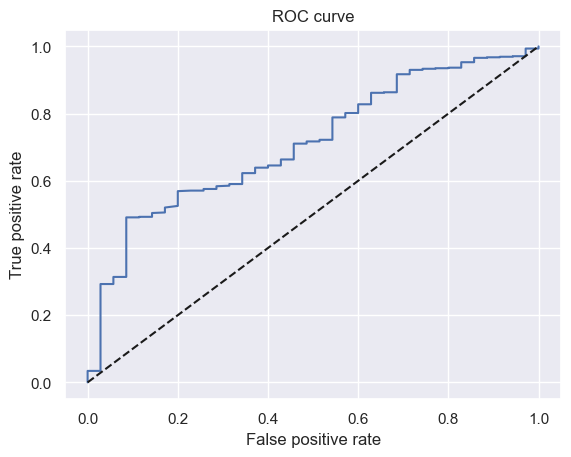

In [56]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [57]:
# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) on our test set
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
AUROC

0.710801393728223

In [58]:
# calculate Gini from AUROC
Gini = AUROC * 2 - 1
Gini

0.4216027874564461

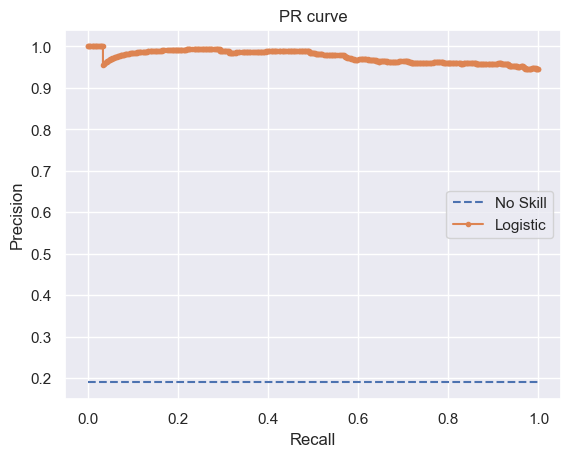

In [59]:
# draw a PR curve
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test == 1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

In [60]:
# calculate PR AUC
auc_pr = auc(recall, precision)
auc_pr

0.9756242135186175

In [61]:
summary_table

,Feature name,Coefficients
0,Intercept,0.535530
1,Loan_Amount:<500000,0.000000
2,Loan_Amount:500000-1000000,0.000000
3,Loan_Amount:>1000000,0.000000
4,Age_Years:21 to 25,-0.435279
5,Age_Years:26 to 30,-0.143138
6,Age_Years:31 to 40,-0.435279
7,Age_Years:41 to 50,-0.143138
8,Age_Years:51 to 55,-0.893833
9,Age_Years:>55,-0.478292


In [62]:
# We create a new dataframe with one column. Its values are the values from the 'reference_categories' list. We name it 'Feature name'.
df_ref_categories = pd.DataFrame(ref_categories, columns = ['Feature name'])
# We create a second column, called 'Coefficients', which contains only 0 values.
df_ref_categories['Coefficients'] = 0
df_ref_categories

,Feature name,Coefficients
0,Loan_Amount,0
1,Age_Years,0
2,Marital_Status,0
3,Level_of_Education,0
4,Employment_Type,0
5,Total_Years_of_Service,0
6,Number_of_years_at_Present_Employment,0
7,Grade,0
8,Monthly_Income,0
9,Accommodation,0


In [63]:
# Concatenates two dataframes.
df_scorecard = pd.concat([summary_table, df_ref_categories])
# We reset the index of a dataframe.
df_scorecard.reset_index(inplace = True)
df_scorecard

,index,Feature name,Coefficients
0,0,Intercept,0.535530
1,1,Loan_Amount:<500000,0.000000
2,2,Loan_Amount:500000-1000000,0.000000
3,3,Loan_Amount:>1000000,0.000000
4,4,Age_Years:21 to 25,-0.435279
...,...,...,...
63,8,Monthly_Income,0.000000
64,9,Accommodation,0.000000
65,10,Average_Balances_last_6_Months,0.000000
66,11,Geo-Region,0.000000


In [64]:
# create a new column, called 'Original feature name', which contains the value of the 'Feature name' column, up to the column symbol.
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]
df_scorecard

,index,Feature name,Coefficients,Original feature name
0,0,Intercept,0.535530,Intercept
1,1,Loan_Amount:<500000,0.000000,Loan_Amount
2,2,Loan_Amount:500000-1000000,0.000000,Loan_Amount
3,3,Loan_Amount:>1000000,0.000000,Loan_Amount
4,4,Age_Years:21 to 25,-0.435279,Age_Years
...,...,...,...,...
63,8,Monthly_Income,0.000000,Monthly_Income
64,9,Accommodation,0.000000,Accommodation
65,10,Average_Balances_last_6_Months,0.000000,Average_Balances_last_6_Months
66,11,Geo-Region,0.000000,Geo-Region


In [65]:
# Define the min and max threshholds for our scorecard
min_score = 300
max_score = 850

In [66]:
# calculate the sum of the minimum coefficients of each category within the original feature name
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
# calculate the sum of the maximum coefficients of each category within the original feature name
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
# create a new columns that has the imputed calculated Score based on the multiplication of the coefficient by the ratio of the differences between
# maximum & minimum score and maximum & minimum sum of cefficients.
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
# update the calculated score of the Intercept (i.e. the default score for each loan)
df_scorecard.loc[0, 'Score - Calculation'] = ((df_scorecard.loc[0,'Coefficients'] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
# round the values of the 'Score - Calculation' column and store them in a new column
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary
0,0,Intercept,0.535530,Intercept,533.934665,534.0
1,1,Loan_Amount:<500000,0.000000,Loan_Amount,0.000000,0.0
2,2,Loan_Amount:500000-1000000,0.000000,Loan_Amount,0.000000,0.0
3,3,Loan_Amount:>1000000,0.000000,Loan_Amount,0.000000,0.0
4,4,Age_Years:21 to 25,-0.435279,Age_Years,-19.998352,-20.0
...,...,...,...,...,...,...
63,8,Monthly_Income,0.000000,Monthly_Income,0.000000,0.0
64,9,Accommodation,0.000000,Accommodation,0.000000,0.0
65,10,Average_Balances_last_6_Months,0.000000,Average_Balances_last_6_Months,0.000000,0.0
66,11,Geo-Region,0.000000,Geo-Region,0.000000,0.0


In [67]:
# check the min and max possible scores of our scorecard
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

300.0
851.0


In [68]:
pd.options.display.max_rows = 102
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference
0,0,Intercept,0.535530,Intercept,533.934665,534.0,0.065335
1,1,Loan_Amount:<500000,0.000000,Loan_Amount,0.000000,0.0,0.000000
2,2,Loan_Amount:500000-1000000,0.000000,Loan_Amount,0.000000,0.0,0.000000
3,3,Loan_Amount:>1000000,0.000000,Loan_Amount,0.000000,0.0,0.000000
4,4,Age_Years:21 to 25,-0.435279,Age_Years,-19.998352,-20.0,-0.001648
5,5,Age_Years:26 to 30,-0.143138,Age_Years,-6.576313,-7.0,-0.423687
6,6,Age_Years:31 to 40,-0.435279,Age_Years,-19.998352,-20.0,-0.001648
7,7,Age_Years:41 to 50,-0.143138,Age_Years,-6.576313,-7.0,-0.423687
8,8,Age_Years:51 to 55,-0.893833,Age_Years,-41.066059,-41.0,0.066059
9,9,Age_Years:>55,-0.478292,Age_Years,-21.974533,-22.0,-0.025467


In [69]:
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard.loc[0, 'Score - Final'] = 555
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,0.535530,Intercept,533.934665,534.0,0.065335,555.0
1,1,Loan_Amount:<500000,0.000000,Loan_Amount,0.000000,0.0,0.000000,0.0
2,2,Loan_Amount:500000-1000000,0.000000,Loan_Amount,0.000000,0.0,0.000000,0.0
3,3,Loan_Amount:>1000000,0.000000,Loan_Amount,0.000000,0.0,0.000000,0.0
4,4,Age_Years:21 to 25,-0.435279,Age_Years,-19.998352,-20.0,-0.001648,-20.0
5,5,Age_Years:26 to 30,-0.143138,Age_Years,-6.576313,-7.0,-0.423687,-7.0
6,6,Age_Years:31 to 40,-0.435279,Age_Years,-19.998352,-20.0,-0.001648,-20.0
7,7,Age_Years:41 to 50,-0.143138,Age_Years,-6.576313,-7.0,-0.423687,-7.0
8,8,Age_Years:51 to 55,-0.893833,Age_Years,-41.066059,-41.0,0.066059,-41.0
9,9,Age_Years:>55,-0.478292,Age_Years,-21.974533,-22.0,-0.025467,-22.0


In [70]:
print(df_scorecard.groupby('Original feature name')['Score - Final'].min().sum())
print(df_scorecard.groupby('Original feature name')['Score - Final'].max().sum())

321.0
872.0


In [71]:
X_test_woe_transformed = woe_transform.fit_transform(X_test)
# insert an Intercept column in its beginning to align with the # of rows in scorecard
X_test_woe_transformed.insert(0, 'Intercept', 1)
X_test_woe_transformed.head()

,Intercept,Loan_Amount:<500000,Loan_Amount:500000-1000000,Loan_Amount:>1000000,Age_Years:21 to 25,Age_Years:26 to 30,Age_Years:31 to 40,Age_Years:41 to 50,Age_Years:51 to 55,Age_Years:>55,Marital_Status:Single,Marital_Status:Married,Level_of_Education:Non Graduate,Level_of_Education:Graduate,Level_of_Education:Post Graduate,Employment_Type:Govt Parastatal,Employment_Type:Private Company,Employment_Type:Quoted Company,Total_Years_of_Service:1 to 3,Total_Years_of_Service:10 to 15,Total_Years_of_Service:4 to 7,Total_Years_of_Service:8 to 10,Total_Years_of_Service:Above 15,Number_of_years_at_Present_Employment:1,Number_of_years_at_Present_Employment:2,Number_of_years_at_Present_Employment:3,Number_of_years_at_Present_Employment:4,Number_of_years_at_Present_Employment:5,Number_of_years_at_Present_Employment:>5,Grade:Senior Manager,Grade:Junior level,Grade:Middle Manager,Monthly_Income:<100000,Monthly_Income:100000-500000,Monthly_Income:>500000,Accommodation:Rented,Accommodation:Owned,Accommodation:Staying with Family,Average_Balances_last_6_Months:<100000,Average_Balances_last_6_Months:100000-500000,Average_Balances_last_6_Months:>500000,Geo-Region:Abuja,Geo-Region:Lagos,Geo-Region:North Central,Geo-Region:North East,Geo-Region:North West,Geo-Region:South East,Geo-Region:South South,Geo-Region:South West,OCCUPATION:BUSINESS TRADER,OCCUPATION:CIVIL SERVANT,OCCUPATION:EDUCATIONIST,OCCUPATION:MILITARY PERSONNEL,OCCUPATION:OTHERS,OCCUPATION:PROFESSIONAL
0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [72]:
scorecard_scores = df_scorecard['Score - Final']
# check the shapes of test set and scorecard before doing matrix dot multiplication
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(650, 55)
(68,)


In [73]:
X_test_woe_transformed = pd.concat([X_test_woe_transformed, pd.DataFrame(dict.fromkeys(ref_categories, [0] * len(X_test_woe_transformed)), 
                                                                         index = X_test_woe_transformed.index)], axis = 1)
# Need to reshape scorecard_scores so that it is (68,1) to allow for matrix dot multiplication
scorecard_scores = scorecard_scores.values.reshape(68, 1)
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(650, 68)
(68, 1)


In [74]:
y_scores = X_test_woe_transformed.dot(scorecard_scores)
y_scores

,0
0,566.0
1,581.0
2,570.0
3,518.0
4,484.0
...,...
645,543.0
646,504.0
647,521.0
648,485.0


In [75]:
y_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       650 non-null    float64
dtypes: float64(1)
memory usage: 5.2 KB


In [76]:
y_scores = y_scores.rename(columns = {0: 'Score'}, inplace = False)

In [77]:
y_scores.sort_values(by='Score')

,Score
453,426.0
162,435.0
333,435.0
596,438.0
586,439.0
...,...
184,707.0
368,714.0
54,721.0
510,723.0


In [78]:
# Calculate Youden's J-Statistic to identify the best threshhold
J = tpr - fpr
# locate the index of the largest J
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold: %f' % (best_thresh))

Best Threshold: 0.289625


In [79]:
# update the threshold value
tr = best_thresh
# crate a new column for the predicted class based on predicted probabilities and threshold
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

array([[0.01692308, 0.03692308],
       [0.08307692, 0.86307692]])

In [80]:
# create a new DF comprising of the thresholds from the ROC output
df_cutoffs = pd.DataFrame(thresholds, columns = ['thresholds'])
# calcue Score corresponding to each threshold
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * 
                       ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()
df_cutoffs

,thresholds,Score
0,0.092335,404.0
1,0.108832,413.0
2,0.112679,415.0
3,0.117121,417.0
4,0.118090,417.0
...,...,...
577,0.978873,686.0
578,0.981880,693.0
579,0.984456,700.0
580,0.984903,701.0


In [81]:
#We define a function called 'n_approved' which assigns a value of 1 if a predicted probability
# is greater than the parameter p, which is a threshold, and a value of 0, if it is not.
# Then it sums the column.
# Thus, for given any percentage values, the function will return
# the number of rows wih estimated probabilites greater than the threshold. 
def n_approved(p):
    return np.where(y_test_proba['y_hat_test_proba'] >= p, 1, 0).sum()

In [82]:
# Assuming that all credit applications above a given probability of being 'good' will be approved,
# when we apply the 'n_approved' function to a threshold, it will return the number of approved applications.
# Thus, here we calculate the number of approved appliations for al thresholds.
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)
# Then, we calculate the number of rejected applications for each threshold.
# It is the difference between the total number of applications and the approved applications for that threshold.
df_cutoffs['N Rejected'] = y_test_proba['y_hat_test_proba'].shape[0] - df_cutoffs['N Approved']
# Approval rate equalts the ratio of the approved applications and all applications.
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / y_test_proba['y_hat_test_proba'].shape[0]
# Rejection rate equals one minus approval rate.
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']
df_cutoffs

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
0,0.092335,404.0,650,0,1.000000,0.000000
1,0.108832,413.0,649,1,0.998462,0.001538
2,0.112679,415.0,648,2,0.996923,0.003077
3,0.117121,417.0,647,3,0.995385,0.004615
4,0.118090,417.0,646,4,0.993846,0.006154
...,...,...,...,...,...,...
577,0.978873,686.0,6,644,0.009231,0.990769
578,0.981880,693.0,4,646,0.006154,0.993846
579,0.984456,700.0,3,647,0.004615,0.995385
580,0.984903,701.0,2,648,0.003077,0.996923


In [83]:
df_cutoffs[df_cutoffs['thresholds'].between(0.184472, 0.24489)] 
#you can change the values to have a look at the approval and rejection rates at your ideal threshold

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
14,0.184979,441.0,636,14,0.978462,0.021538
15,0.191600,443.0,635,15,0.976923,0.023077
16,0.192483,443.0,634,16,0.975385,0.024615
17,0.192970,444.0,633,17,0.973846,0.026154
18,0.193757,444.0,632,18,0.972308,0.027692
19,0.195121,444.0,631,19,0.970769,0.029231
20,0.198137,445.0,630,20,0.969231,0.030769
21,0.201078,446.0,629,21,0.967692,0.032308
22,0.201155,446.0,628,22,0.966154,0.033846
23,0.211559,449.0,627,23,0.964615,0.035385
